# Train and fit network for dialanine with rotationally invariant featurization

All files in working directory specified in `SimulationData` object

### Input:
* dihedrals: `dihedrals.npy`
* features: `features.npy`

### Network:
* `data/vampnet.pt`: $\zeta(x)$, for training
* SRV object : $\psi(x)$
* `data/srv.pt`: $s(x)$, for openmmtorch.
* $x$ is a Tensor with shape (num_frames, num_features)
* $\psi(x)$ is a Tensor with shape (num_frames, num_eigvecs)
* $s$ is a Tensor with shape (num_frames, num_cvs)

### Output:
* `eigvals.npy` : $\lambda_i(\tau)$, $~\tau$ = `sd.lagtime`, in ps, shape (num_eigvecs,)
* `timescales.npy` : $\tau_i = -\tau / \log \lambda_i(\tau)$, in ps, shape (num_eigvecs,)
* `psi.npy` : $[\psi_1(x_t) ... \psi_n(x_t)]$ for dataset, shape (num_frames, num_eigvecs)
* `cvs.npy` : $[s_1, s_2] = [\psi_1, \psi_2]$ for dataset, shape (num_frames, num_eigvecs)
* `theta_grid.npy` : dihedral grid values $\in [-\pi, \pi]$, shape (num_points,)
* `psi_grid.npy` : values of $[\psi_1 ... \psi_n]$ for dihedral angles in grid, shape (num_points, num_points, num_eigvecs)
* `cvs_grid.npy` : values of $[s_1, s_2]$ for dihedral angles in grid, shape (num_points, num_points, num_cvs)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import mdtraj as md
import os
from tqdm.notebook import tqdm

from src.data import MDShareData, OpenMMData
from src.vampnet import VAMPNet, SRV

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')
    torch.set_num_threads(12)

%config Completer.use_jedi = False
print(f'{device = }, {torch.backends.cudnn.enabled = }')
print(f'{torch.cuda.is_available() = }, {torch.__version__ = }')

device = device(type='cuda'), torch.backends.cudnn.enabled = True
torch.cuda.is_available() = True, torch.__version__ = '1.9.0'


# Select dataset

sd.dihedrals.shape = (3000000, 2)


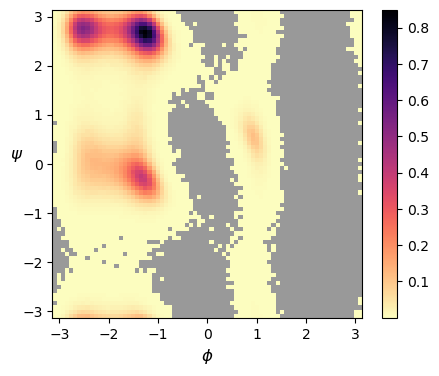

In [30]:
from src.plots import plot_dihedrals_hist2d

# sd = MDShareData('data/mdshare')
sd = OpenMMData('data/ala2_solv')
# sd = OpenMMData('data/ala2_solv.0.05ps', lagframes=20)

print(f'{sd.dihedrals.shape = }')
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_dihedrals_hist2d(fig, ax, sd.dihedrals)
fig.savefig('figures/dihedral-hist2d-solv.png', bbox_inches='tight')
fig.savefig('figures/dihedral-hist2d-solv.svg', bbox_inches='tight')

# Train network on this dataset (or read it from file)

In [3]:
num_features = 45
num_eigvecs = 6
num_cvs = 2
fn_vampnet = 'data/vampnet.pt'
fn_srv = 'data/srv.pt'
train_network = False

if train_network:
    net = nn.Sequential(
        nn.BatchNorm1d(num_features),
        nn.Linear(num_features, 100), nn.ELU(),
        nn.Linear(100, 100), nn.ELU(),
        nn.Linear(100, 30), nn.ELU(),
        nn.Linear(30, num_eigvecs), nn.Tanh()
    )
    # net = nn.Sequential(
    #     nn.BatchNorm1d(num_features),
    #     nn.Linear(num_features, 20), nn.ELU(),
    #     nn.Linear(20, 20), nn.ELU(),
    #     nn.Linear(20, 20), nn.ELU(),
    #     nn.Linear(20, 20), nn.ELU(),
    #     nn.Linear(20, 20), nn.ELU(),
    #     nn.Linear(20, num_eigvecs), nn.Tanh()
    # )

    num_test = round(len(sd.dataset) * 0.1)
    num_train = len(sd.dataset) - num_test
    num_epochs = 10

    data_train, data_test = random_split(sd.dataset, [num_train, num_test])
    dl_train = DataLoader(data_train, batch_size=10_000, shuffle=True)
    dl_test = DataLoader(data_test, batch_size=len(data_test), shuffle=False)

    vampnet = VAMPNet(net, learning_rate=5e-3, device=device)
    vampnet.fit(dl_train, dl_test, num_epochs=num_epochs_run, progress=tqdm)
    torch.save(vampnet, fn_vampnet)
else:
    vampnet = torch.load(fn_vampnet)

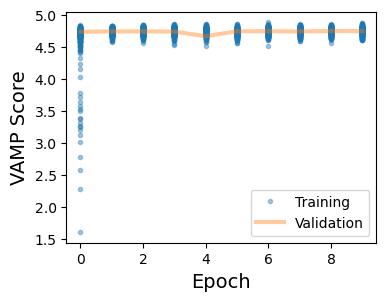

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# ax.semilogx(*vampnet.train_scores.T, '.', alpha=0.6, label='Training')
# ax.semilogx(*vampnet.test_scores.T, '.', alpha=0.6, label='Validation')
ax.plot(*vampnet.train_scores.T, '.', alpha=0.4, label='Training')
ax.plot(*vampnet.test_scores.T, '-', linewidth=3, alpha=0.4, label='Validation')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('VAMP Score', fontsize=14)
ax.legend()
fig.savefig('figures/train.png', bbox_inches='tight')
fig.savefig('figures/train.svg', bbox_inches='tight')

# Fit SRV, save dataset results and $s(x)$ net for openmm-torch

In [7]:
fit_network = False

if fit_network:
    srv = SRV(vampnet.net, sd.lagtime)
    srv.fit(sd.dataset)
    sd.save_eigen_data(srv)
    sd.save_dihedral_grid_data()
    torch.save(srv.srv_net(), fn_srv)

# Eigenfunctions, eigenvalues

In [8]:
from src.plots import check_eigfuncs
for i, ts in enumerate(sd.timescales):
    print(f'tau_{i+1} = {ts:.2f} ps')
for i, ev in enumerate(sd.eigvals):
    print(f'lambda_{i+1}({sd.lagtime} ps) = {ev:.3f}')
check_eigfuncs(sd.psi)

tau_1 = 1441.54 ps
tau_2 = 59.82 ps
tau_3 = 26.54 ps
tau_4 = 2.27 ps
tau_5 = 1.51 ps
tau_6 = 1.16 ps
lambda_1(1.0 ps) = 0.999
lambda_2(1.0 ps) = 0.983
lambda_3(1.0 ps) = 0.963
lambda_4(1.0 ps) = 0.643
lambda_5(1.0 ps) = 0.516
lambda_6(1.0 ps) = 0.422
E[psi_1] = -3.63e-08 	 E[psi_1^2] = 1.00000
E[psi_2] = 3.25e-08 	 E[psi_2^2] = 1.00000
E[psi_3] = -7.78e-07 	 E[psi_3^2] = 1.00000
E[psi_4] = 2.05e-07 	 E[psi_4^2] = 1.00000
E[psi_5] = 6.05e-08 	 E[psi_5^2] = 1.00000
E[psi_6] = 8.05e-08 	 E[psi_6^2] = 1.00000
E[psi_1 psi_2] = -2.63e-08
E[psi_1 psi_3] = -4.95e-08
E[psi_1 psi_4] = -1.18e-07
E[psi_1 psi_5] = -3.71e-07
E[psi_1 psi_6] = 9.99e-08
E[psi_2 psi_3] = -3.89e-09
E[psi_2 psi_4] = 1.77e-07
E[psi_2 psi_5] = 5.21e-07
E[psi_2 psi_6] = 1.40e-07
E[psi_3 psi_4] = 1.04e-07
E[psi_3 psi_5] = 1.66e-07
E[psi_3 psi_6] = -3.21e-08
E[psi_4 psi_5] = 6.83e-08
E[psi_4 psi_6] = 4.53e-07
E[psi_5 psi_6] = 1.70e-06


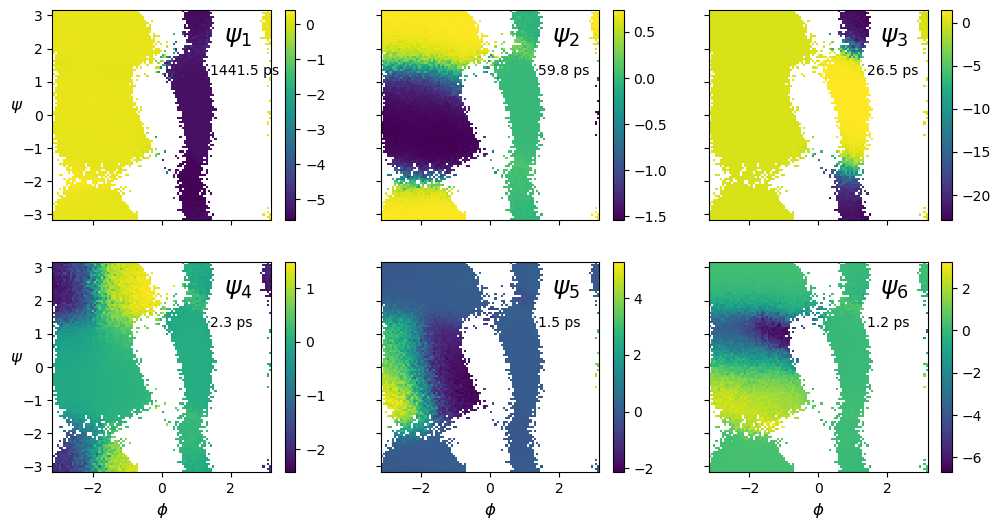

In [26]:
from src.plots import plot_eigfuncs

# fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
plot_eigfuncs(fig, axs, sd.theta_grid, sd.psi_grid, sd.timescales)
fig.savefig('figures/eigfuncs-solv.png', bbox_inches='tight')
fig.savefig('figures/eigfuncs-solv.svg', bbox_inches='tight')

# Dataset CV distributions

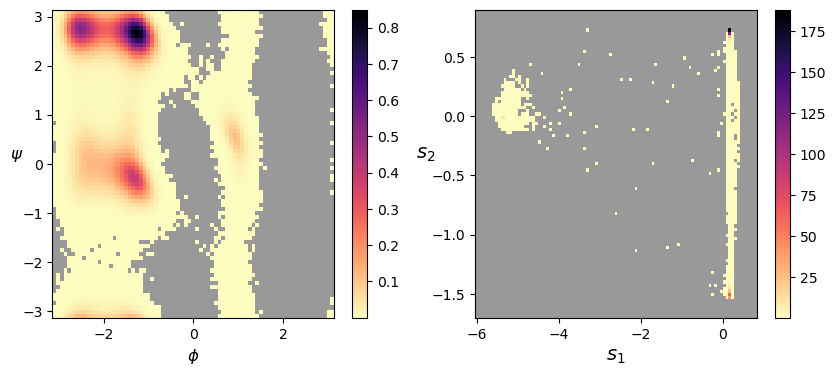

In [27]:
from src.util import sgrids
from src.plots import plot_cvs_hist2d

s1, s2 = sgrids(sd.cvs)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_dihedrals_hist2d(fig, axs[0], sd.dihedrals)
plot_cvs_hist2d(fig, axs[1], s1, s2, sd.cvs)
fig.savefig('figures/cvs-hist2d-solv.png', bbox_inches='tight')
fig.savefig('figures/cvs-hist2d-solv.svg', bbox_inches='tight')